## تعریف ساختار فرآیند (Process)

در این بخش یک کلاس برای نگهداری اطلاعات هر فرآیند تعریف می‌کنیم:
- شناسه فرآیند (pid)
- زمان ورود (arrivalTime)
- زمان اجرای مورد نیاز (burstTime)
- زمان باقی‌مانده (remainingTime)
- زمان انتظار (waitingTime)
- زمان بازگشت (turnaroundTime)
- زمان اتمام (completionTime)

In [1]:
class Process:
    def __init__(self, pid, arrivalTime, burstTime):
        self.pid = pid
        self.arrivalTime = arrivalTime
        self.burstTime = burstTime
        self.remainingTime = burstTime
        self.waitingTime = 0
        self.turnaroundTime = 0
        self.completionTime = 0

## الگوریتم Round Robin

ورودی:
- لیستی از فرآیندها
- مقدار time quantum
- هزینه context switching

الگوریتم تا زمانی که همه فرآیندها کامل شوند ادامه می‌دهد.

In [2]:
from collections import deque

def round_robin(processes, quantum, context_switch):
    n = len(processes)
    time = 0
    completed = 0
    ready_queue = deque()
    in_queue = [False] * n

    processes.sort(key=lambda p: p.arrivalTime)

    for i, p in enumerate(processes):
        if p.arrivalTime <= time:
            ready_queue.append(i)
            in_queue[i] = True

    while completed < n:
        if not ready_queue:
            time += 1
            for i, p in enumerate(processes):
                if p.arrivalTime <= time and not in_queue[i]:
                    ready_queue.append(i)
                    in_queue[i] = True
            continue

        index = ready_queue.popleft()
        process = processes[index]

        if process.remainingTime > quantum:
            time += quantum
            process.remainingTime -= quantum
            time += context_switch
            ready_queue.append(index)
        else:
            time += process.remainingTime
            process.remainingTime = 0
            process.completionTime = time
            process.turnaroundTime = time - process.arrivalTime
            process.waitingTime = process.turnaroundTime - process.burstTime
            completed += 1

        for i, p in enumerate(processes):
            if p.arrivalTime <= time and not in_queue[i] and p.remainingTime > 0:
                ready_queue.append(i)
                in_queue[i] = True

    return processes

## اجرای برنامه با داده نمونه

ورودی نمونه بر اساس مثال موجود در کد C++:

In [3]:
process_list = [
    Process(1, 2, 1),
    Process(2, 4, 5),
    Process(3, 6, 1)
]

quantum = 2
context_switch = 1

result = round_robin(process_list, quantum, context_switch)

print("PID\tArrival\tBurst\tCompletion\tTurnaround\tWaiting")
for p in result:
    print(f"{p.pid}\t{p.arrivalTime}\t{p.burstTime}\t{p.completionTime}\t\t{p.turnaroundTime}\t\t{p.waitingTime}")

avg_waiting = sum(p.waitingTime for p in result) / len(result)
avg_turnaround = sum(p.turnaroundTime for p in result) / len(result)
print(f"\nAverage Waiting Time: {avg_waiting:.5f}")
print(f"Average Turnaround Time: {avg_turnaround:.5f}")

PID	Arrival	Burst	Completion	Turnaround	Waiting
1	2	1	3		1		0
2	4	5	12		8		3
3	6	1	11		5		4

Average Waiting Time: 2.33333
Average Turnaround Time: 4.66667


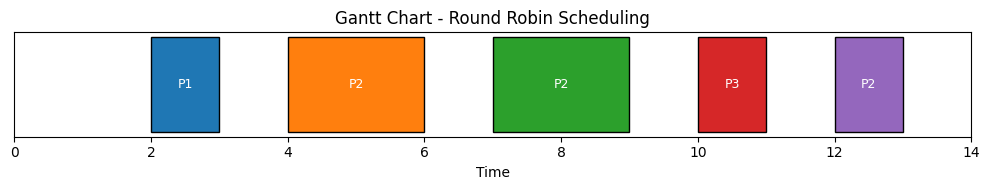

In [4]:
import matplotlib.pyplot as plt

# اجرای واقعی الگوریتم، همراه با ثبت گانت چارت
def round_robin_with_gantt(processes, quantum, context_switch):
    n = len(processes)
    time = 0
    queue = []
    in_queue = [False] * n
    completed = 0
    gantt_chart = []  # لیست برای نگه‌داری [(pid, start_time, end_time)]

    processes.sort(key=lambda x: x['arrival'])

    # اضافه کردن پردازه‌هایی که از ابتدا آماده‌اند
    for i in range(n):
        if processes[i]['arrival'] <= time:
            queue.append(i)
            in_queue[i] = True

    while completed < n:
        if not queue:
            time += 1
            for i in range(n):
                if processes[i]['arrival'] <= time and not in_queue[i]:
                    queue.append(i)
                    in_queue[i] = True
            continue

        index = queue.pop(0)

        start_time = time
        if processes[index]['remaining'] > quantum:
            time += quantum
            processes[index]['remaining'] -= quantum
            queue.append(index)
        else:
            time += processes[index]['remaining']
            processes[index]['completion'] = time
            processes[index]['turnaround'] = time - processes[index]['arrival']
            processes[index]['waiting'] = processes[index]['turnaround'] - processes[index]['burst']
            processes[index]['remaining'] = 0
            completed += 1

        gantt_chart.append((processes[index]['pid'], start_time, time))

        time += context_switch

        # اضافه کردن پردازه‌هایی که تا این لحظه رسیده‌اند و هنوز در صف نیستند
        for i in range(n):
            if processes[i]['arrival'] <= time and not in_queue[i] and processes[i]['remaining'] > 0:
                queue.append(i)
                in_queue[i] = True

    return gantt_chart


# داده‌های ورودی
processes = [
    {'pid': 1, 'arrival': 2, 'burst': 1, 'remaining': 1},
    {'pid': 2, 'arrival': 4, 'burst': 5, 'remaining': 5},
    {'pid': 3, 'arrival': 6, 'burst': 1, 'remaining': 1}
]

quantum = 2
context_switch = 1

gantt = round_robin_with_gantt(processes, quantum, context_switch)

# رسم گانت چارت
fig, ax = plt.subplots(figsize=(10, 2))
for pid, start, end in gantt:
    ax.barh(0, end - start, left=start, edgecolor='black', label=f'P{pid}')
    ax.text((start + end) / 2, 0, f'P{pid}', va='center', ha='center', color='white', fontsize=9)

ax.set_yticks([])
ax.set_xlabel("Time")
ax.set_title("Gantt Chart - Round Robin Scheduling")
ax.set_xlim(0, max([end for _, _, end in gantt]) + 1)
plt.tight_layout()
plt.show()